In [ ]:
# Imports

import pandas as pd
from pathlib import Path
import ast
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [2]:
# Paths

processed_abstracts_path = Path("../../data/processed/abstracts")
save_path = processed_abstracts_path / "total_results"

ml_methods_path = processed_abstracts_path / "regex_scispacy/abstracts_with_ml_methods_regex.csv"
ml_category_path = processed_abstracts_path / "scibert_2/abstracts_with_predictions.csv"
production_category_path = processed_abstracts_path / "umap_kmean_tuned/abstracts_with_clusters.csv"
prod_cluster_keywords_path = processed_abstracts_path / "umap_kmean_tuned/cluster_keywords.json"

# Ensure directories exist
for p in [processed_abstracts_path, save_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")

All directories verified/created.


In [3]:
# Load Data

# ML-methods
df_ml_methods = pd.read_csv(ml_methods_path)

# ML-category
df_ml_category = pd.read_csv(ml_category_path)

# Production category
df_prod_category = pd.read_csv(production_category_path)

# Production cluster keywords
with open(prod_cluster_keywords_path, "r", encoding="utf-8") as f:
    prod_cluster_keywords = json.load(f)

In [4]:
# Check columns
print(df_ml_methods.columns)
print(df_ml_category.columns)
print(df_prod_category.columns)

Index(['query_id', 'eid', 'doi', 'title', 'abstract', 'clean_abs',
       'ml_methods_regex', 'method_count'],
      dtype='object')
Index(['query_id', 'eid', 'doi', 'title', 'abstract', 'clean_abs',
       'is_supervised', 'is_unsupervised', 'is_reinforcement',
       'pred_is_supervised', 'pred_is_unsupervised', 'pred_is_reinforcement'],
      dtype='object')
Index(['query_id', 'eid', 'doi', 'title', 'abstract', 'clean_abs', 'umap_x',
       'umap_y', 'kmeans_cluster'],
      dtype='object')


In [5]:
# Check head of each dataset
df_ml_methods.head(2)

,query_id,eid,doi,title,abstract,clean_abs,ml_methods_regex,method_count
0,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,[],0
1,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",[],0


In [6]:
df_ml_category.head(2)

,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
0,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,False,False,False,0,0,1
1,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",False,False,False,0,0,1


In [7]:
df_prod_category.head(2)

,query_id,eid,doi,title,abstract,clean_abs,umap_x,umap_y,kmeans_cluster
0,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,5.887230,2.385923,3
1,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",5.282488,4.524463,11


In [8]:
df_ml_category.info()
print()
df_ml_methods.info()
print()
df_prod_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33130 entries, 0 to 33129
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   query_id               33130 non-null  object
 1   eid                    33130 non-null  object
 2   doi                    33129 non-null  object
 3   title                  33130 non-null  object
 4   abstract               33130 non-null  object
 5   clean_abs              33129 non-null  object
 6   is_supervised          33130 non-null  bool  
 7   is_unsupervised        33130 non-null  bool  
 8   is_reinforcement       33130 non-null  bool  
 9   pred_is_supervised     33130 non-null  int64 
 10  pred_is_unsupervised   33130 non-null  int64 
 11  pred_is_reinforcement  33130 non-null  int64 
dtypes: bool(3), int64(3), object(6)
memory usage: 2.4+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33130 entries, 0 to 33129
Data columns (total 8 columns):
 #   Colu

In [9]:
# Config

ID_COL = "doi"
RAW_ML_METHOD_COL = "ml_methods_regex"
ML_METHOD_COL = "ml_method"
ML_CAT_COL = "ml_category"
RAW_PROD_CAT_COL = "kmeans_cluster"
PROD_CAT_COL = "prod_category"



In [10]:
# Build ML categories per axis

ml_pred_cols = ["pred_is_supervised", "pred_is_unsupervised", "pred_is_reinforcement"]

ml_long = (
    df_ml_category[[ID_COL] + ml_pred_cols]
    .melt(id_vars=ID_COL, var_name="ml_axis", value_name="is_active")
)

ml_long = ml_long[ml_long["is_active"] == 1].copy()

ml_long[ML_CAT_COL] = ml_long["ml_axis"].map({
    "pred_is_supervised": "supervised",
    "pred_is_unsupervised": "unsupervised",
    "pred_is_reinforcement": "reinforcement",
})

ml_long = ml_long[[ID_COL, ML_CAT_COL]]

ml_long[ML_CAT_COL].value_counts()


ml_category
reinforcement    15627
supervised       12682
unsupervised      5418
Name: count, dtype: int64

In [11]:
# Parse ML method list column

def parse_method_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    s = str(x).strip()
    if not s or s == "[]":
        return []
    try:
        v = ast.literal_eval(s)
        if isinstance(v, list):
            return v
        return [str(v)]
    except (ValueError, SyntaxError):
        return [s]

df_ml_methods["ml_methods_list"] = df_ml_methods[RAW_ML_METHOD_COL].apply(parse_method_list)
df_ml_methods[[RAW_ML_METHOD_COL, "ml_methods_list"]].head(5)


,ml_methods_regex,ml_methods_list
0,[],[]
1,[],[]
2,[],[]
3,[],[]
4,[],[]


In [12]:
# Explode methods to one row per doi–method

df_methods_long = (
    df_ml_methods[[ID_COL, "ml_methods_list"]]
    .explode("ml_methods_list")
    .rename(columns={"ml_methods_list": ML_METHOD_COL})
)

df_methods_long = df_methods_long[
    df_methods_long[ML_METHOD_COL].notna()
    & (df_methods_long[ML_METHOD_COL].astype(str).str.strip() != "")
]

df_methods_long.head()


,doi,ml_method
5,10.3390/asi6050076,Linear Regression
6,10.1016/j.resconrec.2023.107073,Support Vector Regression
6,10.1016/j.resconrec.2023.107073,Linear Regression
6,10.1016/j.resconrec.2023.107073,Gradient Boosting
11,10.30638/eemj.2023.018,Neural Network


In [13]:
# Production categories

df_prod_long = (
    df_prod_category[[ID_COL, RAW_PROD_CAT_COL]]
    .rename(columns={RAW_PROD_CAT_COL: PROD_CAT_COL})
)

df_prod_long.head()


,doi,prod_category
0,10.1016/B978-0-443-33740-6.00012-8,3
1,10.1080/19397038.2025.2563271,11
2,10.1109/TEMSCON-ASPAC62480.2024.11025082,10
3,10.1188/23.CJON.595-601,3
4,10.1039/d3va00106g,1


In [14]:
# Full long table: one row per doi–method–ml_category–prod_category

df_all = (
    df_methods_long[[ID_COL, ML_METHOD_COL]]
    .merge(ml_long, on=ID_COL, how="inner")
    .merge(df_prod_long, on=ID_COL, how="inner")
)

print(df_all.shape)
df_all.head()


(29570, 4)


,doi,ml_method,ml_category,prod_category
0,10.3390/asi6050076,Linear Regression,supervised,10
1,10.1016/j.resconrec.2023.107073,Support Vector Regression,supervised,10
2,10.1016/j.resconrec.2023.107073,Linear Regression,supervised,10
3,10.1016/j.resconrec.2023.107073,Gradient Boosting,supervised,10
4,10.30638/eemj.2023.018,Neural Network,supervised,10


In [15]:
# Quick sanity check and neural network count

print("ML categories:")
print(df_all[ML_CAT_COL].value_counts())

print("\nProduction categories:")
print(df_all[PROD_CAT_COL].value_counts())

print("\nExample methods:")
print(df_all[ML_METHOD_COL].value_counts().head(20))


ML categories:
ml_category
supervised       20086
reinforcement     5127
unsupervised      4357
Name: count, dtype: int64

Production categories:
prod_category
0     5131
12    3387
6     2832
1     2681
10    2548
2     2268
7     1894
8     1670
5     1649
3     1597
11    1347
9     1311
4     1255
Name: count, dtype: int64

Example methods:
ml_method
Neural Network                  6728
Random Forest                   3448
Support Vector Machine          2531
Decision Tree                   1802
Convolutional Neural Network    1291
Gradient Boosting               1285
XGBoost                         1204
LSTM                            1118
Linear Regression                990
K-Nearest Neighbors              940
Principal Component Analysis     937
Bayesian Method                  930
Genetic Algorithm                857
Support Vector Regression        778
Particle Swarm Optimization      615
Logistic Regression              541
K-Means                          533
SHAP          

In [16]:
# Counts per (ML category, production category, method)

group_cols = [ML_CAT_COL, PROD_CAT_COL, ML_METHOD_COL]

method_counts = (
    df_all
    .groupby(group_cols)[ID_COL]
    .nunique()
    .reset_index(name="n_articles")
)

method_counts.head()


,ml_category,prod_category,ml_method,n_articles
0,reinforcement,0,ARIMA,5
1,reinforcement,0,Bayesian Method,60
2,reinforcement,0,Convolutional Neural Network,37
3,reinforcement,0,Decision Tree,36
4,reinforcement,0,Deep Neural Network,10


In [17]:
# Total unique articles per (ML category, production category)

cell_totals = (
    df_all
    .groupby([ML_CAT_COL, PROD_CAT_COL])[ID_COL]
    .nunique()
    .reset_index(name="cell_total")
)

cell_totals.head()


,ml_category,prod_category,cell_total
0,reinforcement,0,387
1,reinforcement,1,406
2,reinforcement,2,223
3,reinforcement,3,220
4,reinforcement,4,129


In [18]:
# Order categories by frequency of unique articles

ml_cat_order = (
    df_all
    .groupby(ML_CAT_COL)[ID_COL]
    .nunique()
    .sort_values(ascending=False)
    .index
    .tolist()
)

prod_cat_order = (
    df_all
    .groupby(PROD_CAT_COL)[ID_COL]
    .nunique()
    .sort_values(ascending=False)
    .index
    .tolist()
)

ml_cat_order, prod_cat_order


(['supervised', 'reinforcement', 'unsupervised'],
 [0, 12, 1, 6, 10, 2, 5, 11, 8, 7, 3, 9, 4])

In [19]:
# Top-k methods per cell

TOP_K = 3

method_counts["rank_in_cell"] = (
    method_counts
    .groupby([ML_CAT_COL, PROD_CAT_COL])["n_articles"]
    .rank(method="dense", ascending=False)
)

top_methods = (
    method_counts[method_counts["rank_in_cell"] <= TOP_K]
    .merge(cell_totals, on=[ML_CAT_COL, PROD_CAT_COL], how="left")
    .sort_values([ML_CAT_COL, PROD_CAT_COL, "n_articles"], ascending=[True, True, False])
)

top_methods.head(10)


,ml_category,prod_category,ml_method,n_articles,rank_in_cell,cell_total
2,reinforcement,0,Neural Network,218,1.0,387
1,reinforcement,0,LSTM,83,2.0,387
0,reinforcement,0,Bayesian Method,60,3.0,387
5,reinforcement,1,Neural Network,287,1.0,406
4,reinforcement,1,Genetic Algorithm,91,2.0,406
3,reinforcement,1,Bayesian Method,47,3.0,406
8,reinforcement,2,Neural Network,152,1.0,223
6,reinforcement,2,Bayesian Method,34,2.0,223
7,reinforcement,2,Genetic Algorithm,20,3.0,223
11,reinforcement,3,Neural Network,107,1.0,220


In [20]:
# Build 2D map summary

def summarize_cell(group):
    total = int(group["cell_total"].iloc[0])
    methods_str = ", ".join(
        f"{m} ({int(n)})"
        for m, n in zip(group[ML_METHOD_COL], group["n_articles"])
    )
    return pd.Series({"summary": f"n={total}; top: {methods_str}"})

cell_summary = (
    top_methods
    .groupby([ML_CAT_COL, PROD_CAT_COL])
    .apply(summarize_cell)
    .reset_index()
)

cell_summary.head()


/tmp/ipykernel_3582678/602492248.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_cell)


,ml_category,prod_category,summary
0,reinforcement,0,"n=387; top: Neural Network (218), LSTM (83), B..."
1,reinforcement,1,"n=406; top: Neural Network (287), Genetic Algo..."
2,reinforcement,2,"n=223; top: Neural Network (152), Bayesian Met..."
3,reinforcement,3,"n=220; top: Neural Network (107), Explainable ..."
4,reinforcement,4,"n=129; top: Neural Network (72), LSTM (24), Ba..."


In [21]:
# Pivot to 2D grid

summary_grid = cell_summary.pivot(
    index=ML_CAT_COL,
    columns=PROD_CAT_COL,
    values="summary"
)

summary_grid = summary_grid.reindex(index=ml_cat_order, columns=prod_cat_order)

summary_grid


prod_category,0,12,1,6,10,2,5,11,8,7,3,9,4
ml_category,,,,,,,,,,,,,
supervised,"n=1417; top: Neural Network (512), Random Fore...","n=1138; top: Neural Network (558), Random Fore...","n=831; top: Neural Network (318), Random Fores...","n=888; top: Random Forest (415), Neural Networ...","n=705; top: Random Forest (284), Neural Networ...","n=770; top: Neural Network (310), Random Fores...","n=495; top: Neural Network (211), Random Fores...","n=341; top: Neural Network (110), Random Fores...","n=582; top: Neural Network (303), Support Vect...","n=554; top: Random Forest (220), Neural Networ...","n=498; top: Random Forest (163), Support Vecto...","n=361; top: Neural Network (137), Random Fores...","n=406; top: Neural Network (132), Random Fores..."
reinforcement,"n=387; top: Neural Network (218), LSTM (83), B...","n=414; top: Neural Network (312), Bayesian Met...","n=406; top: Neural Network (287), Genetic Algo...","n=204; top: Neural Network (120), LSTM (29), R...","n=370; top: Neural Network (215), LSTM (95), G...","n=223; top: Neural Network (152), Bayesian Met...","n=310; top: Neural Network (220), Bayesian Met...","n=462; top: Neural Network (228), Decision Tre...","n=162; top: Neural Network (129), Bayesian Met...","n=192; top: Neural Network (124), Particle Swa...","n=220; top: Neural Network (107), Explainable ...","n=169; top: Neural Network (113), Deep Neural ...","n=129; top: Neural Network (72), LSTM (24), Ba..."
unsupervised,"n=641; top: Neural Network (231), Principal Co...","n=194; top: Neural Network (92), Principal Com...","n=102; top: Principal Component Analysis (48),...","n=165; top: Neural Network (60), Principal Com...","n=114; top: Neural Network (46), K-Means (35),...","n=184; top: Neural Network (79), Principal Com...","n=95; top: Neural Network (48), Principal Comp...","n=86; top: Neural Network (35), K-Means (17), ...","n=176; top: Neural Network (91), Convolutional...","n=149; top: Neural Network (44), Principal Com...","n=139; top: Neural Network (48), K-Means (36),...","n=209; top: Neural Network (95), Random Forest...","n=51; top: Neural Network (19), Principal Comp..."


In [22]:
# Short labels for production clusters based on first 3 keywords

def make_cluster_label(cid):
    cid_str = str(cid)
    if cid_str in prod_cluster_keywords:
        words = prod_cluster_keywords[cid_str][:3]
        return f"{cid} - " + ", ".join(words)
    return str(cid)

prod_cluster_label_map = {
    c: make_cluster_label(c)
    for c in df_all[PROD_CAT_COL].unique()
}

prod_cluster_label_map


{10: '10 - energy, forecasting, power',
 0: '0 - maintenance, predictive maintenance, predictive',
 3: '3 - product, design, business',
 11: '11 - manufacturing, industry, production',
 4: '4 - battery, concrete, batteries',
 1: '1 - process, production, hydrogen',
 12: '12 - process, manufacturing, additive',
 2: '2 - process, quality, machining',
 8: '8 - defect, welding, process',
 5: '5 - process, design, control',
 9: '9 - iot, security, attacks',
 7: '7 - oil, reservoir, production',
 6: '6 - food, crop, agricultural'}

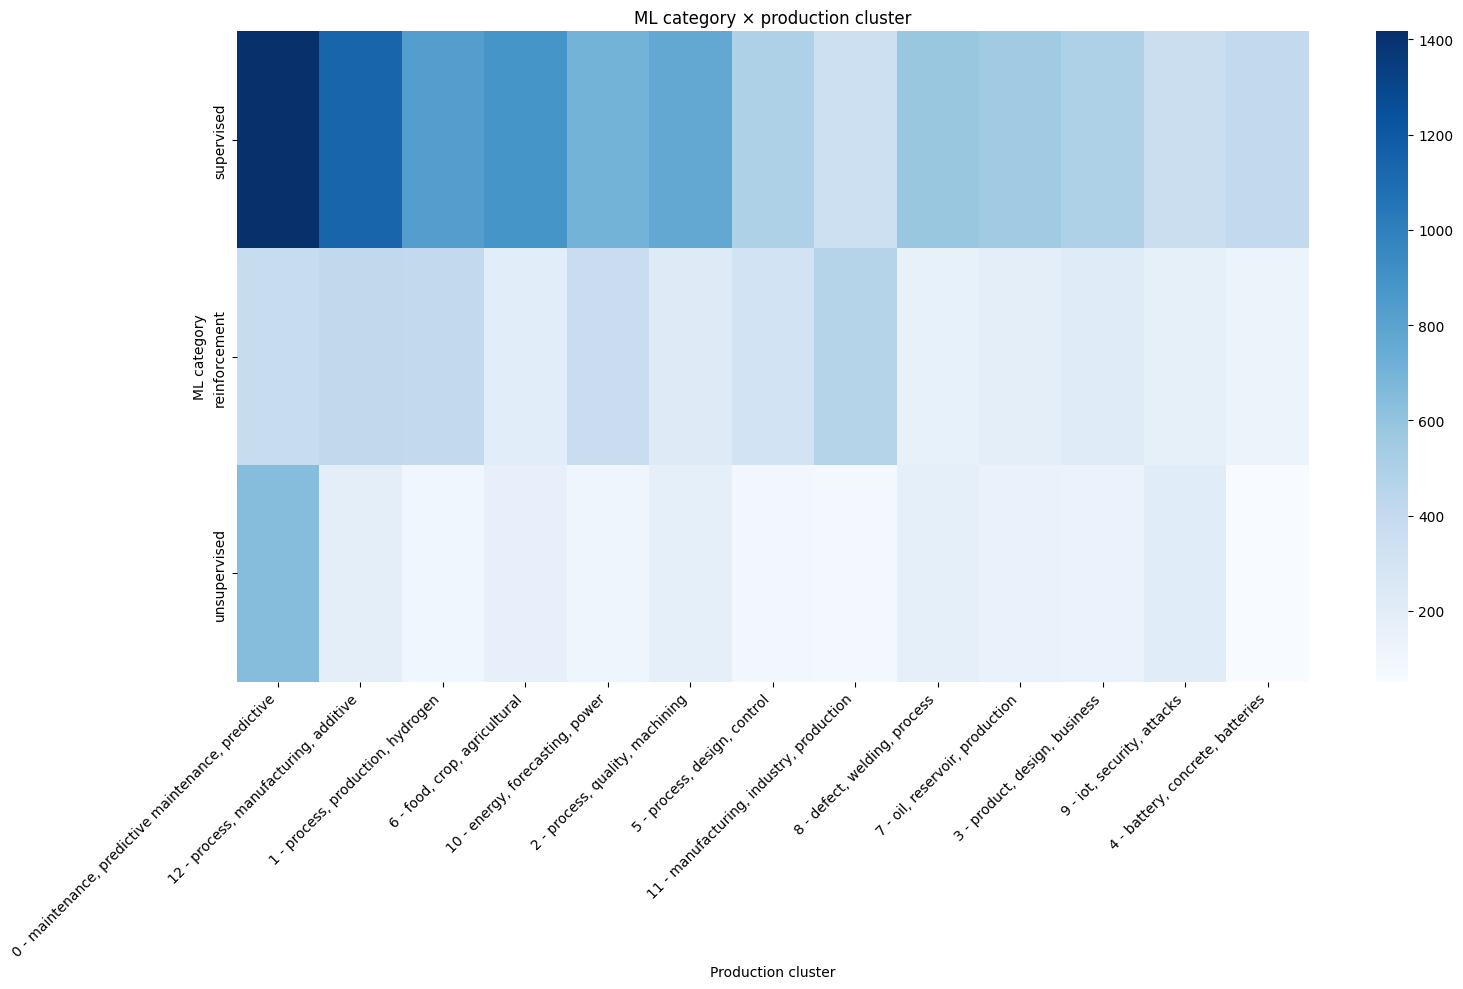

In [23]:
# Numeric grid for heatmap
numeric_grid = (
    cell_totals
    .pivot(index=ML_CAT_COL, columns=PROD_CAT_COL, values="cell_total")
    .reindex(index=ml_cat_order, columns=prod_cat_order)
)

# Text grid (summary)
text_grid = (
    cell_summary
    .pivot(index=ML_CAT_COL, columns=PROD_CAT_COL, values="summary")
    .reindex(index=ml_cat_order, columns=prod_cat_order)
)

plt.figure(figsize=(16, 10))
ax = sns.heatmap(
    numeric_grid,
    # annot=text_grid,
    fmt="",
    cmap="Blues",
    cbar=True
)

ax.set_xlabel("Production cluster")
ax.set_ylabel("ML category")
ax.set_title("ML category × production cluster")

# Apply readable labels on x-axis
xticklabels = [
    prod_cluster_label_map[c]
    for c in numeric_grid.columns
]
ax.set_xticklabels(xticklabels, rotation=45, ha="right")

plt.tight_layout()
plt.show()


In [24]:
bubble_df = cell_summary.merge(cell_totals, on=[ML_CAT_COL, PROD_CAT_COL])

bubble_df["prod_cluster_label"] = bubble_df[PROD_CAT_COL].map(prod_cluster_label_map)

fig = px.scatter(
    bubble_df,
    x="prod_cluster_label",
    y=ML_CAT_COL,
    size="cell_total",
    # text="summary",
    size_max=60
)

fig.update_traces(textposition="top center")
fig.show()


In [26]:
# Label map from cluster id to short description
def make_cluster_label(cid):
    cid_str = str(cid)
    words = prod_cluster_keywords.get(cid_str, [])[:3]
    if words:
        return f"{cid} | " + ", ".join(words)
    return str(cid)

prod_label_map = {cid: make_cluster_label(cid) for cid in prod_cat_order}
prod_label_to_id = {v: k for k, v in prod_label_map.items()}

# Numeric grid for heatmap
numeric_grid = (
    cell_totals
    .pivot(index=ML_CAT_COL, columns=PROD_CAT_COL, values="cell_total")
    .reindex(index=ml_cat_order, columns=prod_cat_order)
)


In [30]:
# Widgets

ml_cat_dropdown = widgets.Dropdown(
    options=ml_cat_order,
    description="ML cat",
    layout=widgets.Layout(width="300px")
)

prod_dropdown = widgets.Dropdown(
    options=[prod_label_map[c] for c in prod_cat_order],
    description="Prod",
    layout=widgets.Layout(width="400px")
)


In [31]:
# Callback for dashboard

def update_dashboard(ml_cat, prod_label, top_k=15):
    prod_id = prod_label_to_id[prod_label]
    
    subset = (
        method_counts
        .query(f"{ML_CAT_COL} == @ml_cat and {PROD_CAT_COL} == @prod_id")
        .sort_values("n_articles", ascending=False)
    )
    
    if subset.empty:
        print(f"No articles for cell: {ml_cat} × {prod_label}")
        return
    
    cell_n = int(
        cell_totals.query(
            f"{ML_CAT_COL} == @ml_cat and {PROD_CAT_COL} == @prod_id"
        )["cell_total"].iloc[0]
    )
    
    print(f"Cell: {ml_cat} × {prod_label}")
    print(f"Unique articles in cell: {cell_n}")
    print("\nTop methods:")
    
    display(subset[[ML_METHOD_COL, "n_articles"]].head(top_k))
    
    top_plot = subset.head(top_k)
    
    plt.figure(figsize=(8, 4))
    plt.barh(top_plot[ML_METHOD_COL].astype(str), top_plot["n_articles"])
    plt.gca().invert_yaxis()
    plt.xlabel("Number of articles")
    plt.title("Top methods in selected cell")
    plt.tight_layout()
    plt.show()


In [32]:
# Bind widgets to callback

ui = widgets.VBox([ml_cat_dropdown, prod_dropdown])

out = widgets.interactive_output(
    update_dashboard,
    {"ml_cat": ml_cat_dropdown, "prod_label": prod_dropdown}
)

display(ui, out)


Output()